In [1]:
import os, sys; sys.path.append(os.path.abspath('../'))

In [2]:
# Crawl the data directory
import os

data_dir = r'..\data\baseline'

data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]
# loop over the files

import scipy.io

All_network_X = []
All_network_y = []

for f in data_files[:10]:
    data = scipy.io.loadmat(f)
    test_x = data['test_x']
    test_out = data['test_out']

    All_network_X.append(test_x)
    All_network_y.append(test_out)

import numpy as np

All_network_X = np.array(All_network_X)
All_network_y = np.array(All_network_y)

In [26]:
y_last_50_avg = All_network_y[:, :, :, -50:]
y_last_50_avg.shape
y_last_50_avg = np.average(y_last_50_avg, axis=3)
y_last_50_avg.shape
y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)
y_last_50_avg.shape

# for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
y_last_50_avg[y_last_50_avg > 0] = 1
y_last_50_avg[y_last_50_avg < 0] = -1

x_nuron_avg = np.average(All_network_X, axis=3)
x_nuron_avg.shape
x_nuron_avg = x_nuron_avg.reshape(10, 4*50, 300)
x_nuron_avg.shape
print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 300) (10, 200)


In [14]:
import itertools
from inspector.dataset import SyntheticNetworks
from matplotlib import pyplot as plt
from netrep.metrics.stochastic import GaussianStochasticMetric

In [15]:
x_nuron_avg = x_nuron_avg[:, :, ::4][:, :, :-1]
y_last_50_avg = y_last_50_avg[:, :]

print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 74) (10, 200)


In [16]:
X1 = x_nuron_avg[0]
y1 = y_last_50_avg[0]

X2 = x_nuron_avg[1]
y2 = y_last_50_avg[1]

X3 = x_nuron_avg[2]
y3 = y_last_50_avg[2]

X4 = x_nuron_avg[3]
y4 = y_last_50_avg[3]

X5 = x_nuron_avg[4]
y5 = y_last_50_avg[4]

In [17]:
X1.shape

(200, 74)

In [18]:
def get_means_and_covs(
    X,
    y
):
    """Helper method that computes class-conditional means and covariances."""
    
    classes = np.unique(y)
    K = len(classes)
    means = np.stack([np.mean(X[y==k], 0) for k in classes], 0) # Meaning: compute the mean of each class
    covs = np.stack([np.cov(X[y==k].T) for k in classes], 0) # Meaning: compute the covariance of each class
    return means, covs

# compute the class-conditional means and covariances for each network
means_x1, covs_x1 = get_means_and_covs(X1, y1)
means_x2, covs_x2 = get_means_and_covs(X2, y2)
means_x3, covs_x3 = get_means_and_covs(X3, y3)
means_x4, covs_x4 = get_means_and_covs(X4, y4)
means_x5, covs_x5 = get_means_and_covs(X5, y5)



print("(means_x1.shape, covs_x2.shape)", (means_x1.shape, covs_x1.shape))

# compile into mu and sigma dicts for easier processing
# means = (means_x1, means_x2, means_x3)
# covs = (covs_x1, covs_x2, covs_x3)
means = (means_x1, means_x2, means_x3, means_x4, means_x5)
covs = (covs_x1, covs_x2, covs_x3, covs_x4, covs_x5)

(means_x1.shape, covs_x2.shape) ((2, 74), (2, 74, 74))


In [19]:
# check NaN in array
np.isnan(covs_x3).any()

False

In [21]:
distmats_w2 = dict()

# compute Wasserstein ground metric for alpha=(0, 1, 2)
for alpha in [1]:
    distmat_w2 = np.zeros((5, 5))
    metric = GaussianStochasticMetric(alpha)
    for i,j in itertools.combinations(range(5), 2): # Meaning: compute the distance between each pair of networks
        
        # the fit method expects a list [means, covs]
        Xi = (means[i], covs[i]) # Meaning: Xi is a tuple of the means and covariances of network i
        Xj = (means[j], covs[j]) # Meaning: Xj is a tuple of the means and covariances of network j


        metric.fit(Xi, Xj)
        distmat_w2[i,j] = metric.score(Xi, Xj)

        # My score printing code
        print(f"alpha {alpha}: Network {i+1} vs Network {j+1} -> score {distmat_w2[i,j]}") # Meaning: print the pair of networks

    # dist matrix is symmetric
    distmat_w2 += distmat_w2.T
    distmats_w2[alpha] = distmat_w2

alpha 1: Network 1 vs Network 2 -> score 16.434113591985547
alpha 1: Network 1 vs Network 3 -> score 10.60126674658388
alpha 1: Network 1 vs Network 4 -> score 3.523596236983555
alpha 1: Network 1 vs Network 5 -> score 1.9828855304218922
alpha 1: Network 2 vs Network 3 -> score 6.162988498974669
alpha 1: Network 2 vs Network 4 -> score 13.147788928803239
alpha 1: Network 2 vs Network 5 -> score 17.24954040094853
alpha 1: Network 3 vs Network 4 -> score 7.214675189037215
alpha 1: Network 3 vs Network 5 -> score 11.308051245182867
alpha 1: Network 4 vs Network 5 -> score 4.327712482068361


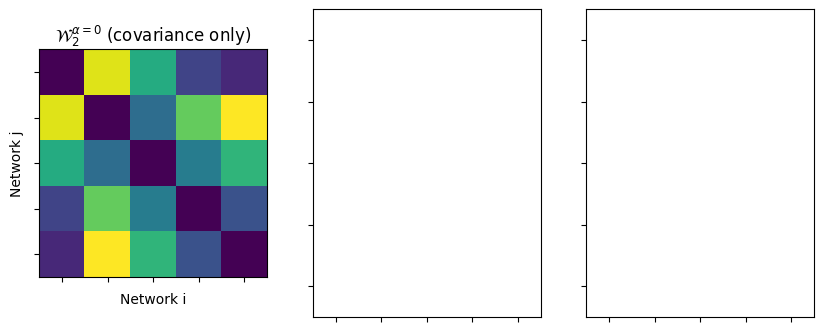

In [22]:
# plot the distmats
titles = [r"$\mathcal{W}_2^{\alpha=0}$" " (covariance only)",
          r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)",
          r"$\mathcal{W}_2^{\alpha=2}$" " (mean only)"]

# All heatmaps share same colorbar limits
_VMAX = max([distmats_w2[k].max() for k in distmats_w2])
_VMIN = min([distmats_w2[k].min() for k in distmats_w2])

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex="all", sharey="all")

for i, a in enumerate(distmats_w2.keys()):
    im = ax[i].imshow(distmats_w2[a], vmin=_VMIN, vmax=_VMAX)
    ax[i].set(title=titles[i])
ax[0].set(xticklabels=[], yticklabels=[], xlabel="Network i", ylabel="Network j");
# plt.colorbar()

In [24]:
distmat_w2.shape

(5, 5)

In [ ]:
from inspector.utility import plot_distmat

plot_distmat(distmat_w2, title=r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)")

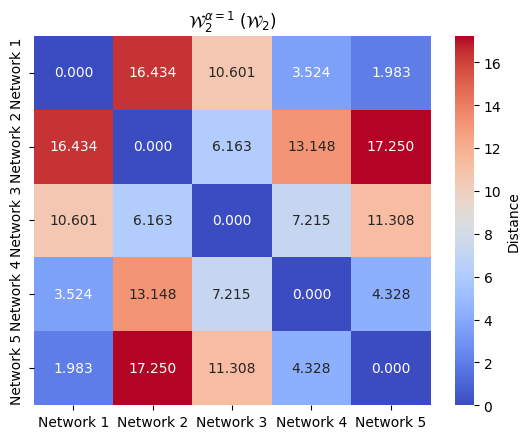

In [25]:
from inspector.utility import plot_distmat

plot_distmat(distmat_w2, title=r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)")

# 10 x 10

In [35]:
y_last_50_avg = All_network_y[:, :, :, -50:]
y_last_50_avg.shape
y_last_50_avg = np.average(y_last_50_avg, axis=3)
y_last_50_avg.shape
y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)
y_last_50_avg.shape

# for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
y_last_50_avg[y_last_50_avg > 0] = 1
y_last_50_avg[y_last_50_avg < 0] = -1

x_nuron_avg = np.average(All_network_X, axis=3)
x_nuron_avg.shape
x_nuron_avg = x_nuron_avg.reshape(10, 4*50, 300)
x_nuron_avg.shape
print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 300) (10, 200)


In [36]:
import itertools
from inspector.dataset import SyntheticNetworks
from matplotlib import pyplot as plt
from netrep.metrics.stochastic import GaussianStochasticMetric

In [37]:
x_nuron_avg = x_nuron_avg[:, :, ::4]
y_last_50_avg = y_last_50_avg[:, :]

print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 75) (10, 200)


In [38]:
def get_means_and_covs(
    X,
    y
):
    """Helper method that computes class-conditional means and covariances."""
    
    classes = np.unique(y)
    K = len(classes)
    means = np.stack([np.mean(X[y==k], 0) for k in classes], 0) # Meaning: compute the mean of each class
    covs = np.stack([np.cov(X[y==k].T) for k in classes], 0) # Meaning: compute the covariance of each class
    return means, covs

# compute the class-conditional means and covariances for each network
means_and_covs = [get_means_and_covs(x_nuron_avg[i], y_last_50_avg[i]) for i in range(10)]

means = [m for m, c in means_and_covs]
covs = [c for m, c in means_and_covs]

In [39]:
means_and_covs[0][0].shape

(2, 75)

In [40]:
distmats_w2 = dict()

# compute Wasserstein ground metric for alpha=(0, 1, 2)
for alpha in [1]:
    distmat_w2 = np.zeros((10, 10))
    metric = GaussianStochasticMetric(alpha)
    for i,j in itertools.combinations(range(10), 2): # Meaning: compute the distance between each pair of networks
        
        # the fit method expects a list [means, covs]
        Xi = (means[i], covs[i]) # Meaning: Xi is a tuple of the means and covariances of network i
        Xj = (means[j], covs[j]) # Meaning: Xj is a tuple of the means and covariances of network j


        metric.fit(Xi, Xj)
        distmat_w2[i,j] = metric.score(Xi, Xj)

        # My score printing code
        print(f"alpha {alpha}: Network {i+1} vs Network {j+1} -> score {distmat_w2[i,j]}") # Meaning: print the pair of networks

    # dist matrix is symmetric
    distmat_w2 += distmat_w2.T
    distmats_w2[alpha] = distmat_w2

alpha 1: Network 1 vs Network 2 -> score 16.553693065362616
alpha 1: Network 1 vs Network 3 -> score 10.644948308927685
alpha 1: Network 1 vs Network 4 -> score 3.5387264626390995
alpha 1: Network 1 vs Network 5 -> score 2.069589703832267
alpha 1: Network 1 vs Network 6 -> score 6.594300353163557
alpha 1: Network 1 vs Network 7 -> score 2.2891079806849985
alpha 1: Network 1 vs Network 8 -> score 4.553147330085228
alpha 1: Network 1 vs Network 9 -> score 3.4538214039316446
alpha 1: Network 1 vs Network 10 -> score 4.198582305301502
alpha 1: Network 2 vs Network 3 -> score 6.240732956003961
alpha 1: Network 2 vs Network 4 -> score 13.259372750921903
alpha 1: Network 2 vs Network 5 -> score 17.403293686693285
alpha 1: Network 2 vs Network 6 -> score 10.154225208454346
alpha 1: Network 2 vs Network 7 -> score 17.484053350999375
alpha 1: Network 2 vs Network 8 -> score 12.570944621479413
alpha 1: Network 2 vs Network 9 -> score 13.374774841215977
alpha 1: Network 2 vs Network 10 -> score 12

In [44]:
import seaborn as sns

def plot_distmat(distmat, title = "Distance Metric", out_path = None):
    '''Plot a distance matrix
    New method uses Seaborn to create a heatmap
    '''

    # Set the x and y ticks to the labels
    number_of_networks = len(distmat[0])
    labels = [f"Network {i+1}" for i in range(number_of_networks)]

    # Create a new figure
    plt.figure()

    # Plot the heatmap using Seaborn
    ax = sns.heatmap(distmat, cmap='coolwarm', annot=True, fmt=".2f",
                     xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Distance'})
    ax.set_title(title)

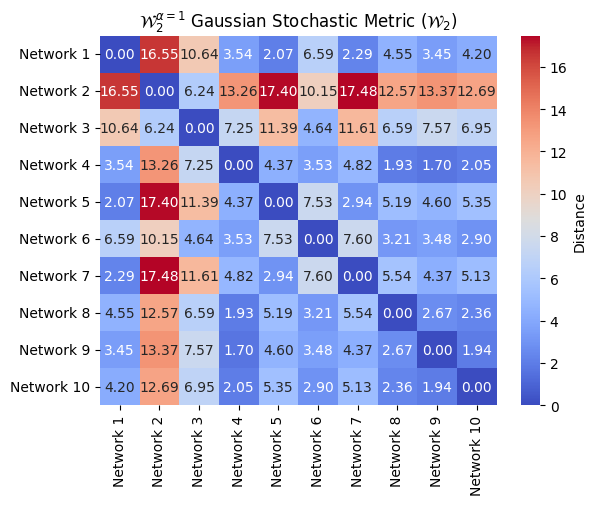

In [45]:

plot_distmat(distmat_w2, title=r"$\mathcal{W}_2^{\alpha=1}$ Gaussian Stochastic Metric" " ($\mathcal{W}_2$)", out_path="gaus_out.png")